In [107]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Do I need all of these?
import sklearn.preprocessing as preprocessing
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)

from IPython.display import display
from numpy.random import RandomState

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn_pandas import DataFrameMapper

In [108]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=make_scorer(roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

In [ ]:

grid_search.fit(X_std, y_enc)
grid_search.best_params_

final_clf = tree.DecisionTreeClassifier(max_depth=7)
final_clf.fit(X_std, y_enc);

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.sort_values(by="rank_test_score").head(5)

# Poisonous mushrooms
Get the data
## Interests
## Munging

In [110]:
df = pd.read_csv('datasets/mushrooms.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

In [111]:
#remove entries with unknown stalk root
df = df[df['stalk-root'] != '?']

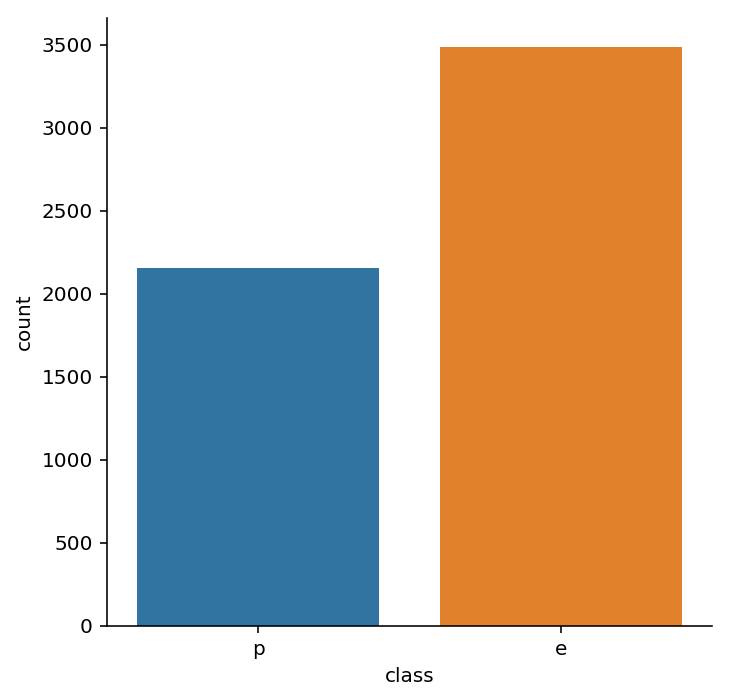

In [112]:
sns.catplot(
    x='class',
    data=df,
    kind='count')

In [113]:
#split off the response variable
y = df['class'].to_frame()
X = df.loc[:, df.columns != 'class']

In [114]:
#encode dummy variables
X_enc = pd.get_dummies(X)

#Scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

In [115]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

### Decision trees

In [116]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_m = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [117]:
gs_dt_m.best_params_

{'criterion': 'gini', 'max_depth': 5}

In [118]:
cv_res_df_m = pd.DataFrame(gs_dt_m.cv_results_)
cv_res_df_m.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.036600,0.007889,0.003191,0.001883,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.886311,0.867749,0.870070,...,0.866667,0.865797,0.863768,0.870145,0.868116,0.867246,0.866957,0.866957,0.866551,0.002013
1,0.034297,0.007107,0.002332,0.000752,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.949749,0.947327,0.941425,...,0.940332,0.941064,0.939283,0.939589,0.942140,0.937243,0.940042,0.942029,0.939883,0.001499
2,0.044496,0.007221,0.003020,0.002448,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.978611,0.973325,0.974485,...,0.975939,0.975443,0.975016,0.975222,0.975870,0.974837,0.973830,0.976877,0.975417,0.000811
3,0.037262,0.007138,0.002969,0.001357,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.997851,0.999284,0.998567,...,0.998925,0.999104,0.998746,0.998925,0.998566,0.999104,0.998746,0.998925,0.998889,0.000176
4,0.032853,0.005441,0.002211,0.000814,gini,5,"{'criterion': 'gini', 'max_depth': 5}",1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


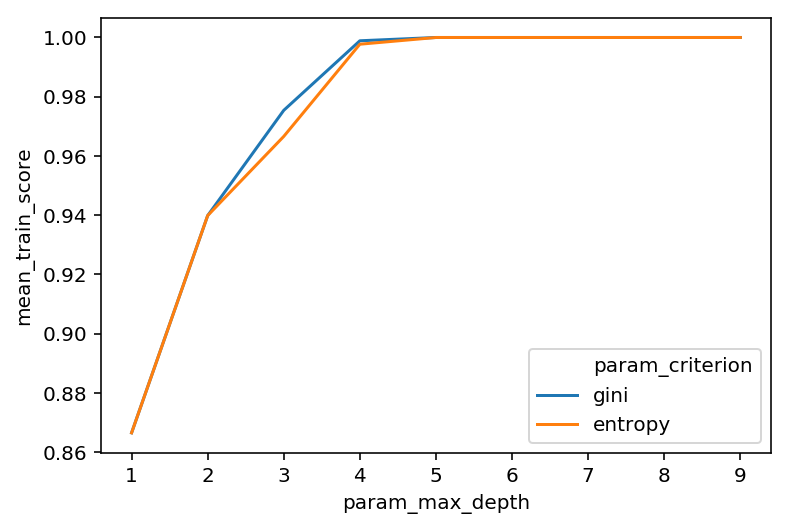

In [119]:
sns.lineplot(
    x='param_max_depth',
    y='mean_train_score',
    hue='param_criterion',
    data=cv_res_df_m)

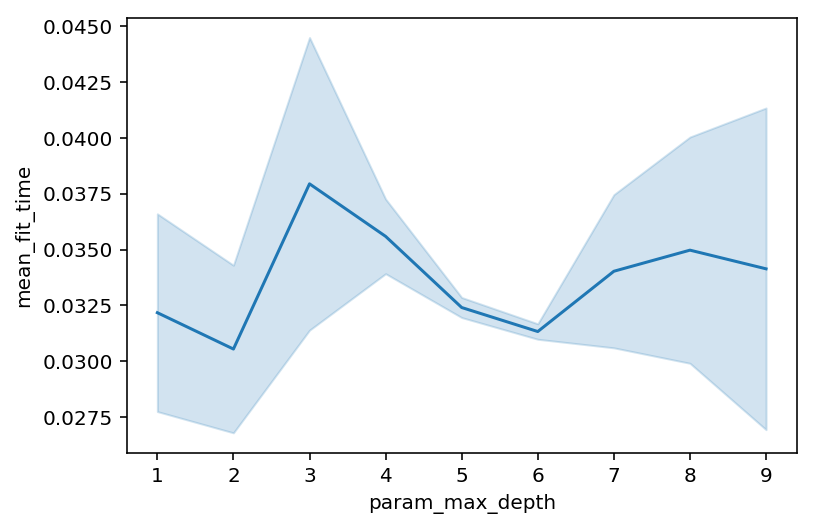

In [121]:
sns.lineplot(
    x='param_max_depth',
    y='mean_fit_time',
    data=cv_res_df_m)

In [122]:
y_pred_m = gs_dt_m.predict(X_std)
accuracy_m = metrics.accuracy_score(y_enc, y_predicted)
AUROC_m = gs_dt_m.score(X_std, y_enc)
confusion_mat_m= metrics.confusion_matrix(y_enc, y_predicted)
prec_recall_fsore_support_m = metrics.precision_recall_fscore_support(y_enc, y_predicted)

In [123]:
prec_recall_fsore_support_m

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([3488, 2156]))

### Boosting

In [124]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_m = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [125]:
gs_rf_m.best_params_

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 24}

### KNN

In [126]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_m = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [127]:
gs_knn_m.best_params_

{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}

### SVM

In [128]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_m = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [129]:
gs_svm_m.best_params_

{'decision_function_shape': 'ovr', 'degree': 1, 'kernel': 'linear'}

### Neural Networks

In [130]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_m = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [131]:
gs_mlp_m.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (6,),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

# Adult incomes
Get the data
## Interests
## Munging

In [132]:
df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']

In [133]:
df = df.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = df['income'].to_frame()
X = df.loc[:, df.columns != 'income']

In [134]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

### Decision Trees

In [135]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_a = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [136]:
gs_dt_a.best_params_

{'criterion': 'gini', 'max_depth': 7}

### Boosting

In [137]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_a = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [140]:
gs_rf_a.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 8}

### K-nearest neighbors

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_a = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
gs_knn_a.best_params_

### SVM

In [ ]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_a = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
gs_svm_a.best_params_

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_a = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
gs_mlp_a.best_params_